#### <i> Medical Images Classification and Enchancement Using ML A Focus on fingerprint colorized data 253513 </i>
#### <i> Import Library Files </i>

#### <i> Dataset Overview </i>

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


# Path to the training data
data_dir = "/kaggle/input/medical-imaging-fingerprint-colorized-img-dataset/Fingerprint Dataset for FVC2000_DB4_B/Fingerprint Dataset for FVC2000_DB4_B/train_data"

# Define transforms: Resize to 224x224, convert to tensor, normalize
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(           # Normalize with ImageNet mean/std (standard for pretrained models)
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Load dataset with ImageFolder - assigns labels based on folder names
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Create DataLoader for batching and shuffling
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

# Print class names (i.e., folder names)
print("Class names (Enhancement Techniques):")
print(dataset.classes)

# Example: Access one image and label
img, label = dataset[0]
print(f"Image shape: {img.shape}, Label index: {label}, Class: {dataset.classes[label]}")


Class names (Enhancement Techniques):
['3D_Rendering', '3D_Volume_Rendering', 'Adaptive_Histogram_Equalization', 'Alpha_Blending', 'Basic_Color_Map', 'Contrast_Stretching', 'Edge_Detection', 'Gamma_Correction', 'Gaussian_Blur', 'Heatmap_Visualization', 'Interactive_Segmentation', 'LUT_Color_Map', 'Random_Color_Palette']
Image shape: torch.Size([3, 128, 128]), Label index: 0, Class: 3D_Rendering


#### <i> Data Preprocessing </i>

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


# Initialize data containers
img_sizes = []
brightness = []
contrast = []
rgb_means = {'R': [], 'G': [], 'B': []}

# Loop through all images in the dataset
for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path): continue
    
    for img_file in os.listdir(cls_path):
        if not img_file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp')): continue
        img_path = os.path.join(cls_path, img_file)
        
        try:
            img = Image.open(img_path).convert("RGB")
            img_np = np.array(img)

            # Store size
            img_sizes.append(img.size)  # (width, height)

            # Brightness = mean pixel intensity
            brightness.append(np.mean(img_np))

            # Contrast = std deviation of pixel intensities
            contrast.append(np.std(img_np))

            # RGB channels mean
            rgb_means['R'].append(np.mean(img_np[:, :, 0]))
            rgb_means['G'].append(np.mean(img_np[:, :, 1]))
            rgb_means['B'].append(np.mean(img_np[:, :, 2]))

        except Exception as e:
            print(f"Error reading {img_path}: {e}")
            continue


#### <i> EDA And Data Visulization </i>

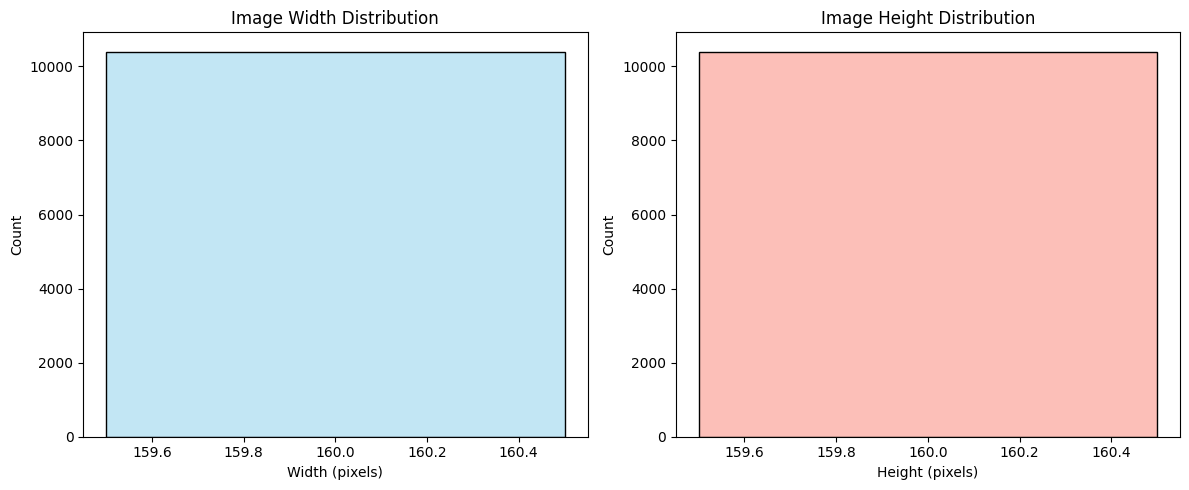

In [3]:
widths, heights = zip(*img_sizes)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(widths, kde=True, color='skyblue')
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")

plt.subplot(1, 2, 2)
sns.histplot(heights, kde=True, color='salmon')
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.tight_layout()
plt.show()


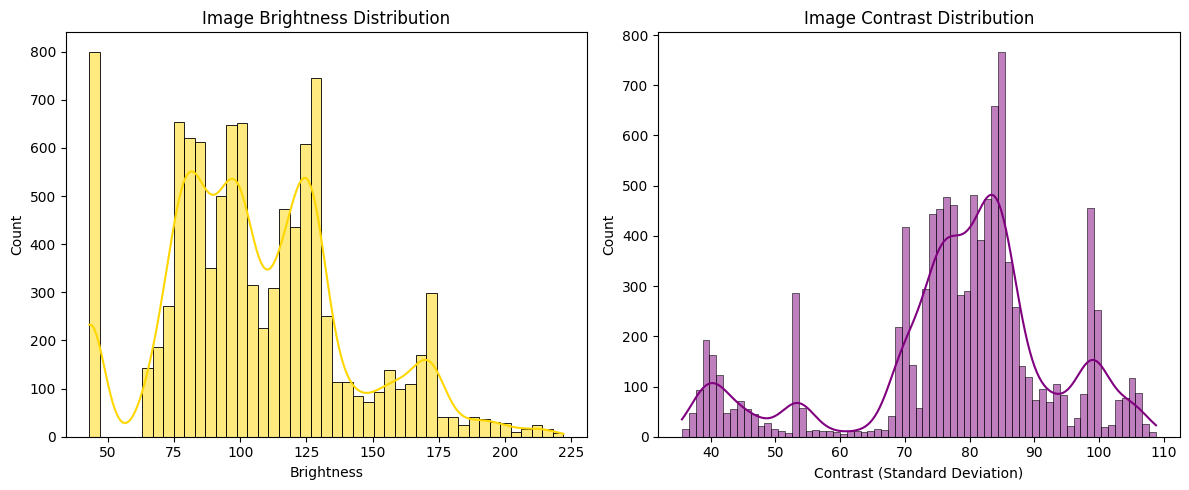

In [4]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(brightness, kde=True, color='gold')
plt.title("Image Brightness Distribution")
plt.xlabel("Brightness")

plt.subplot(1, 2, 2)
sns.histplot(contrast, kde=True, color='purple')
plt.title("Image Contrast Distribution")
plt.xlabel("Contrast (Standard Deviation)")
plt.tight_layout()
plt.show()


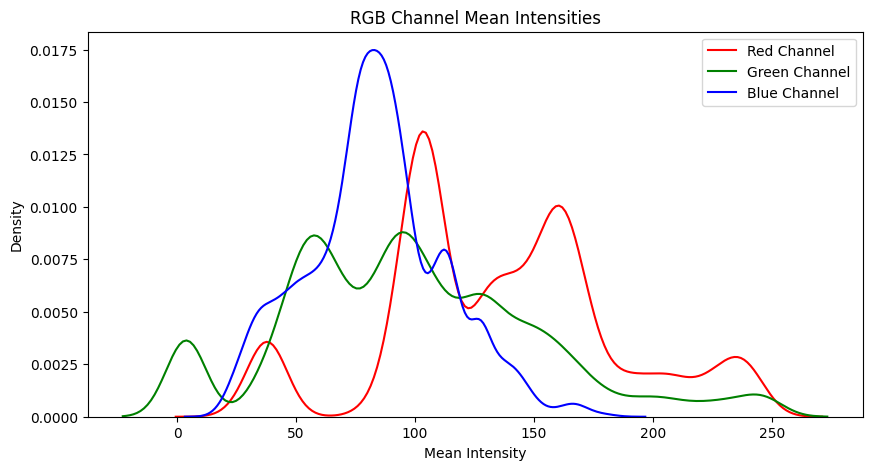

In [5]:
plt.figure(figsize=(10, 5))
sns.kdeplot(rgb_means['R'], label='Red Channel', color='red')
sns.kdeplot(rgb_means['G'], label='Green Channel', color='green')
sns.kdeplot(rgb_means['B'], label='Blue Channel', color='blue')
plt.title("RGB Channel Mean Intensities")
plt.xlabel("Mean Intensity")
plt.legend()
plt.show()


Found 13 classes:
['3D_Rendering', '3D_Volume_Rendering', 'Adaptive_Histogram_Equalization', 'Alpha_Blending', 'Basic_Color_Map', 'Contrast_Stretching', 'Edge_Detection', 'Gamma_Correction', 'Gaussian_Blur', 'Heatmap_Visualization', 'Interactive_Segmentation', 'LUT_Color_Map', 'Random_Color_Palette']


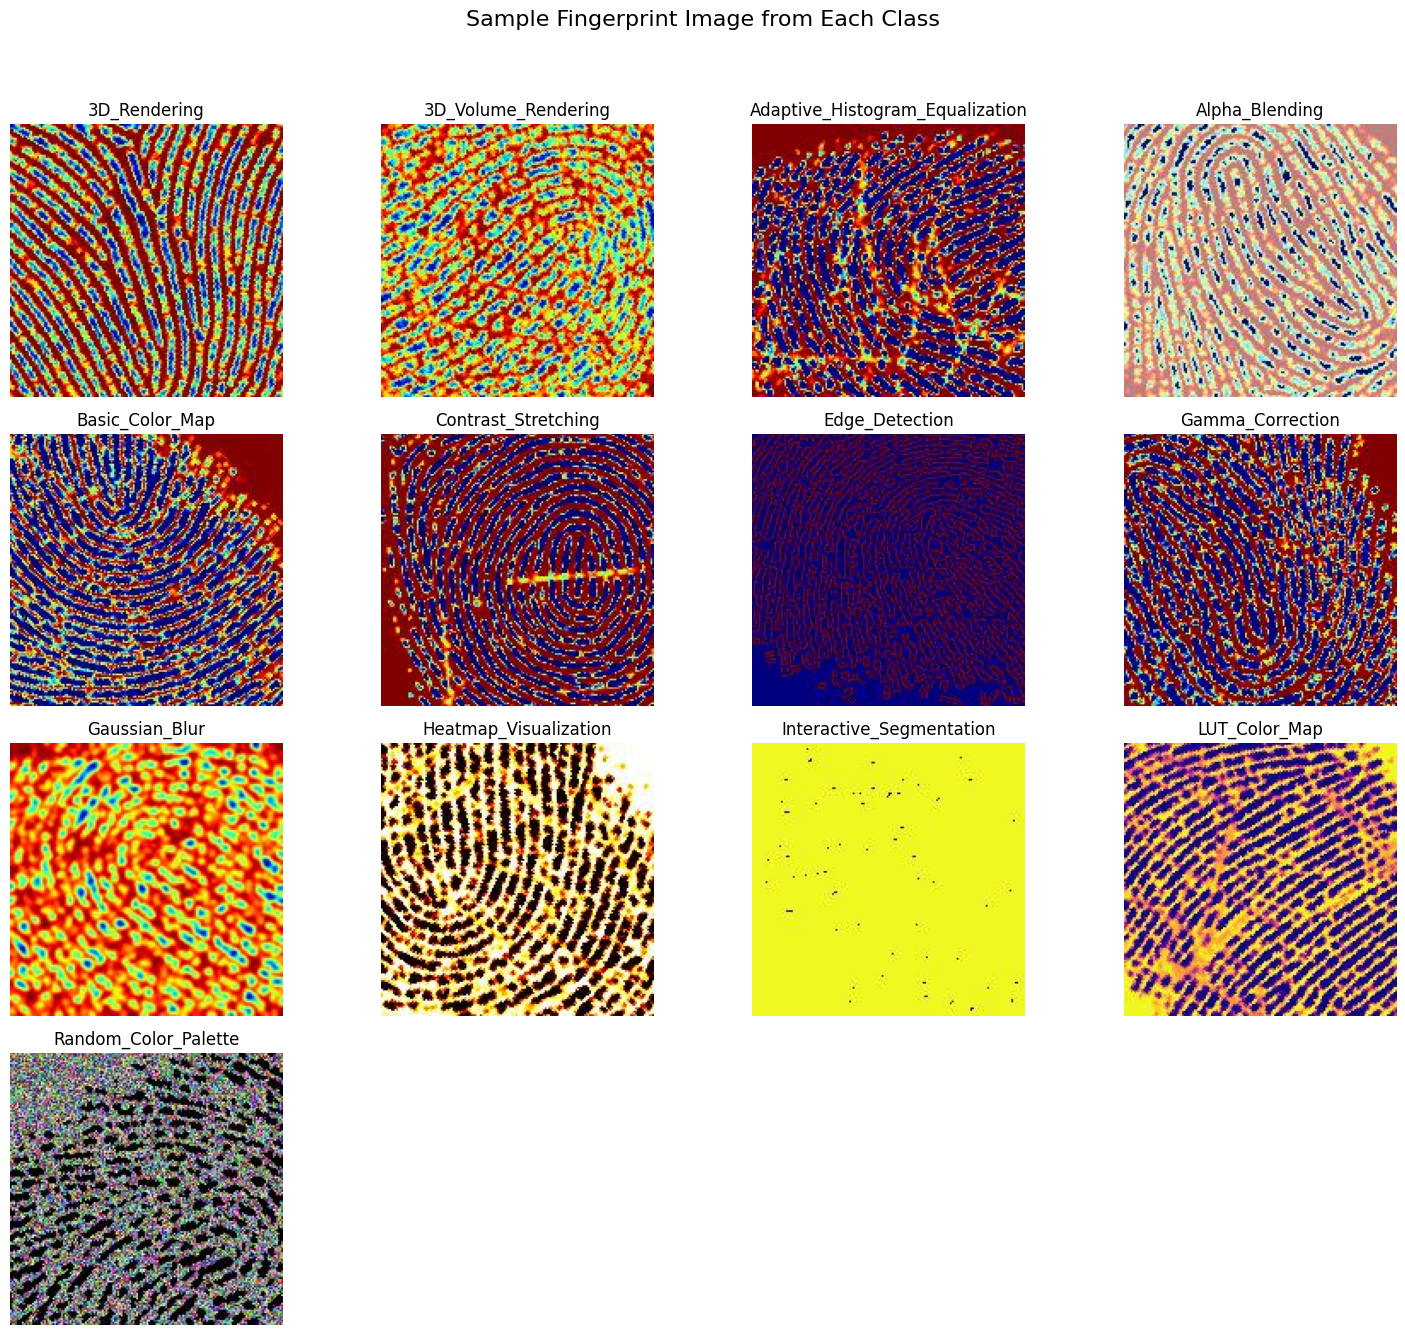

In [6]:
# Get class names (folder names)
class_names = sorted(os.listdir(data_dir))
print(f"Found {len(class_names)} classes:")
print(class_names)

# --- Display sample images from each class ---
num_classes = len(class_names)
cols = 4
rows = (num_classes + cols - 1) // cols

plt.figure(figsize=(15, 3.5 * rows))

for idx, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    
    if image_files:
        img_path = os.path.join(class_path, image_files[0])
        img = Image.open(img_path)

        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

plt.suptitle("Sample Fingerprint Image from Each Class", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### <i> Modeling </i>
#### <i> RestNet </i>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os


# 🔁 Image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   # Mean
                         [0.229, 0.224, 0.225])   # Std
])

# 🗂️ Load dataset and split
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)

# 🧠 Load ResNet18 without pretrained weights (offline-safe)
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(dataset.classes))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ⚙️ Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 🔁 Training loop
for epoch in range(5):
    model.train()
    correct, total = 0, 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += (outputs.argmax(1) == y).sum().item()
        total += y.size(0)
    
    print(f"[ResNet18] Epoch {epoch+1}: Train Accuracy: {correct / total * 100:.2f}%")

# ✅ Validation loop
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in val_dl:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        correct += (outputs.argmax(1) == y).sum().item()
        total += y.size(0)

print(f"[ResNet18] Validation Accuracy: {correct / total * 100:.2f}%")


[ResNet18] Epoch 1: Train Accuracy: 57.87%
[ResNet18] Epoch 2: Train Accuracy: 60.96%
[ResNet18] Epoch 3: Train Accuracy: 62.80%
[ResNet18] Epoch 4: Train Accuracy: 64.13%
[ResNet18] Epoch 5: Train Accuracy: 64.21%
[ResNet18] Validation Accuracy: 63.61%


#### <i> CNN Model </i>

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Smaller for quicker training
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

# Train-validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# Define a small CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    model.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total * 100
    print(f"Epoch {epoch+1}: Train Accuracy: {train_acc:.2f}%")

# Validation
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_acc = correct / total * 100
print(f"Validation Accuracy: {val_acc:.2f}%")


Epoch 1: Train Accuracy: 55.83%
Epoch 2: Train Accuracy: 60.94%
Epoch 3: Train Accuracy: 60.81%
Epoch 4: Train Accuracy: 61.35%
Epoch 5: Train Accuracy: 61.25%
Epoch 6: Train Accuracy: 61.17%
Epoch 7: Train Accuracy: 62.19%
Epoch 8: Train Accuracy: 61.90%
Epoch 9: Train Accuracy: 62.97%
Epoch 10: Train Accuracy: 62.52%
Validation Accuracy: 57.07%


#### <i> MLP Classifier </i>

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#
# Transforms: Resize and Flatten later
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Smaller size = faster
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

# Train/Validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

# Define MLP Model
class MLPClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten image
        return self.fc(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sample_input = next(iter(train_loader))[0]
input_size = sample_input.shape[1] * sample_input.shape[2] * sample_input.shape[3]

model = MLPClassifier(input_size=input_size, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    model.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total * 100
    print(f"Epoch {epoch+1}: Train Accuracy: {train_acc:.2f}%")

# Validation accuracy
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_acc = correct / total * 100
print(f"Validation Accuracy: {val_acc:.2f}%")


Epoch 1: Train Accuracy: 41.33%
Epoch 2: Train Accuracy: 56.90%
Epoch 3: Train Accuracy: 59.54%
Epoch 4: Train Accuracy: 60.75%
Epoch 5: Train Accuracy: 62.07%
Epoch 6: Train Accuracy: 61.44%
Epoch 7: Train Accuracy: 62.07%
Epoch 8: Train Accuracy: 62.70%
Epoch 9: Train Accuracy: 62.22%
Epoch 10: Train Accuracy: 61.49%
Validation Accuracy: 59.52%


#### <i> Comparison Of All Models </i>

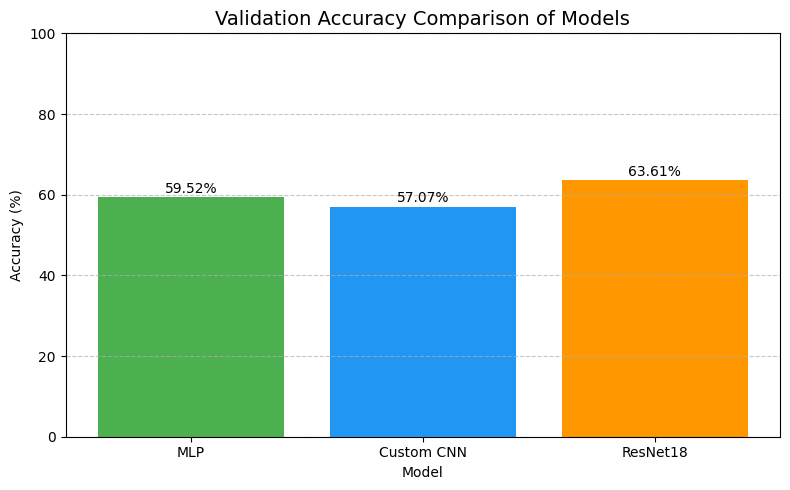

In [10]:
import matplotlib.pyplot as plt

# Results from your previous training
results = {
    "MLP": 59.52,
    "Custom CNN": 57.07,
    "ResNet18": 63.61
}

# Extract data for plotting
models = list(results.keys())
accuracies = list(results.values())

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=["#4caf50", "#2196f3", "#ff9800"])
plt.ylim(0, 100)

# Annotate accuracy on top of bars
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{acc:.2f}%', ha='center', fontsize=10)

# Labels and Title
plt.title("Validation Accuracy Comparison of Models", fontsize=14)
plt.ylabel("Accuracy (%)")
plt.xlabel("Model")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
